In [44]:
%run spot_functions.ipynb
%run gl_functions.ipynb

In [3]:
sdk, robot, id_client, \
robot_state_client, command_client, \
image_client, graph_nav_client, \
world_object_client, manipulation_api_client = initRobot('192.168.50.3')

In [4]:
lease_client, lease, lease_keep_alive = getLease(robot)

In [5]:
powerOn(robot)

True


True

In [45]:
getBattInfo()

Battery at: 73.0 %. Robot has 4153 seconds left


(73.0, 4153)

In [6]:
upload_filepath = "/home/gluser/groundlight/bdspot/spot/loopGraph"
timeout_sec = 10

In [21]:
def makeGLAPICall(det, graph_nav_client):
    
    #MUST CLEAR GRAPH PRIOR TO RUNNING, ARM CAMERA DOES NOT WORK IF GRAPH IS NOT CLEAR
    graph_nav_client.clear_graph()

    cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
    print('Gripper opening')

    moveToAndLookAt([0.61,0,0.5],[1,0,-0.5], True)
    print('looking down')

    capImage(image_client, 'handColorImage.jpg')
    image_query = gl.submit_image_query(detector_id=det.id, image = "handColorImage.jpg")
    
    return image_query

In [22]:
def localizeObject():
    request_fiducials = [world_object_pb2.WORLD_OBJECT_APRILTAG]
    fiducial_objects = world_object_client.list_world_objects(
                object_type=request_fiducials).world_objects

    fid = None
    for fiducial_obj in fiducial_objects:
        if fiducial_obj.apriltag_properties.tag_id == 583:
            fid = fiducial_obj

    fid_tree_snapshot = fid.transforms_snapshot
    frame_tree_snapshot = robot.get_frame_tree_snapshot()
    
    #get_a_tform_b returns transformation such that a_coords = tform * b_coords

    fidToBody = bosdyn.client.frame_helpers.get_a_tform_b(fid_tree_snapshot, frame_a = 'body', frame_b ='filtered_fiducial_583')
    
    #obj fiducial
    # Position must be accurate to about 0.03m in x,y for a reliable grasp
    obj_pose_fid_frame_se2 = bosdyn.client.math_helpers.SE2Pose(-0.25,0,0)

    obj_pose_fid_frame_se3 = bosdyn.client.math_helpers.SE3Pose.from_se2(obj_pose_fid_frame_se2)
    #print(obj_pose_fid_frame_se3)

    obj_pose_body_frame_se3 = (fidToBody * obj_pose_fid_frame_se3)
    #print(obj_pose_body_frame_se3)

    obj_loc_body_frame_proto = obj_pose_body_frame_se3.to_proto().position
    #print(obj_loc_body_frame_proto)

    grasp = manipulation_api_pb2.PickObject(frame_name = 'body', object_rt_frame = obj_loc_body_frame_proto)

    grasp_request = manipulation_api_pb2.ManipulationApiRequest(pick_object = grasp)
    
    return grasp_request

In [23]:
def makeGrasp(grasp_request, graph_nav_client):
    
    graph_nav_client.clear_graph()
    
    cmd_response = manipulation_api_client.manipulation_api_command(
    manipulation_api_request = grasp_request)

    # Get feedback from the robot
    while True:
        feedback_request = manipulation_api_pb2.ManipulationApiFeedbackRequest(
            manipulation_cmd_id=cmd_response.manipulation_cmd_id)

        # Send the request
        response = manipulation_api_client.manipulation_api_feedback_command(
            manipulation_api_feedback_request=feedback_request)

        print('Current state: ',
              manipulation_api_pb2.ManipulationFeedbackState.Name(response.current_state))

        if response.current_state == manipulation_api_pb2.MANIP_STATE_GRASP_SUCCEEDED or response.current_state == manipulation_api_pb2.MANIP_STATE_GRASP_FAILED:
            break

        time.sleep(0.25)

    #creates carry override
    carry_override_rq = manipulation_api_pb2.ApiGraspedCarryStateOverride(override_request = 3)

    #creates override
    override_rq = manipulation_api_pb2.ApiGraspOverrideRequest(
        carry_state_override = carry_override_rq)

    #sends override so object can be stowed and carried
    response = manipulation_api_client.grasp_override_command(grasp_override_request = override_rq)
    
    cmd = RobotCommandBuilder.arm_stow_command()
    cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

In [24]:
def checkForCubeAndGrasp(det, graph_nav_client):
    image_query = makeGLAPICall(det, graph_nav_client)

    grasp_request = None
    if image_query.result.label == 'PASS':
        grasp_request = localizeObject()
        print("RUBIK'S CUBE FOUND and localized")
        makeGrasp(grasp_request, graph_nav_client)
        print("GRASP MADE")
        return True
    else:
        print("NO RUBIK'S CUBE FOUND, continuing walk")
        cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(0.0)
        cmd = RobotCommandBuilder.arm_stow_command()
        cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)
        return False





In [126]:
bdcrc.blocking_selfright(command_client, timeout_sec = timeoutSec)

cmd = RobotCommandBuilder.arm_stow_command()
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)


cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(0.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

bdcrc.blocking_stand(command_client, timeout_sec = timeoutSec)

# InitializeGraph
waypointDict = graphInit(graph_nav_client, upload_filepath)

print('INITALIZED GRAPH')
print("________________")
print("")

Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize the robot using commands (2) or (3) before attempting a navigation command.
attempt #:  0
Error during fiducial localization init:  bosdyn.api.graph_nav.SetLocalizationResponse (ResponseError): Code: 8 (STATUS_NO_MATCHING_FIDUCIAL)
attempt #:  1
Error during fiducial localization init:  bosdyn.api.graph_nav.SetLocalizationResponse (ResponseError): Code: 8 (STATUS_NO_MATCHING_FIDUCIAL)
attempt #:  2
SUCCESS: initialized location to using nearest fiducial
INITALIZED GRAPH
________________



In [11]:

# Initialize Groundlight API

GROUNDLIGHT_API_TOKEN = 'api_2Au8NPiTMbSLQ73Vjr2eMhX2qUh_pt4EEKhtDNgnjN3dUAr89YANDcYsmBkJZV'
gl = Groundlight(api_token=GROUNDLIGHT_API_TOKEN)

detectors = gl.list_detectors()

In [12]:
det = detectors.results[1]
print("INITALIZED GL API WITH DETECTOR:")
print(det)

INITALIZED GL API WITH DETECTOR:
id='det_2AuDZFz06xbytjWrTL0dUvsjOz7' type=<DetectorTypeEnum.detector: 'detector'> created_at=datetime.datetime(2022, 6, 21, 15, 30, 29, 961429, tzinfo=tzoffset(None, -25200)) name='newRubiksCube' query="Is entire Rubik's cube contained within image?" group_name='__DEFAULT' confidence_threshold=0.5


In [33]:
hasCube = False

for loopNum in range(3):
    for wpInd in [10, 9]:
        print('waypoint index:', wpInd, hasCube)
        nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[wpInd], timeoutSec)
        waitUntilFinishedNav(nav_to_cmd_id)
        if wpInd == 9:
            frameTreeSnapshot = robot.get_frame_tree_snapshot()
            cmd = RobotCommandBuilder.synchro_trajectory_command_in_body_frame(0, 0, np.pi/2, frame_tree_snapshot = frameTreeSnapshot)
            cmd_id = cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
            bdcrc.block_for_trajectory_cmd(command_client, cmd_id)
            res = checkForCubeAndGrasp(det, graph_nav_client)
            if(res):
                hasCube = True
            waypointDict = graphInit(graph_nav_client, upload_filepath)
        elif wpInd == 10:
            if hasCube:
                print('CUBE POSSESSED')
                cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
                cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
                print('CUBE DROPPED')
                hasCube = False
                
        

waypoint index: 10 False
waypoint index: 9 False
Gripper opening
looking down
NO RUBIK'S CUBE FOUND, continuing walk
Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize the robot using commands (2) or (3) before attempting a navigation command.
attempt #:  0
SUCCESS: initialized location to using nearest fiducial
waypoint index: 10 False
waypoint index: 9 False
Gripper opening
looking down
RUBIK'S CUBE FOUND and localized
GRASP MADE
Loading the graph from disk into local storage...
Loaded graph has 27 waypoints and 29 edges
Uploading the graph and snapshots to the robot...


Upload complete! The robot is currently not localized to the map; please localize the robot using commands (2) or (3) before attempting a navigation command.
attempt #:  0
SUCCESS: initialized location to using nearest fiducial
waypoint index:

In [7]:
bdcrc.blocking_selfright(command_client, timeout_sec = timeoutSec)

cmd = RobotCommandBuilder.arm_stow_command()
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)


cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(0.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

bdcrc.blocking_stand(command_client, timeout_sec = timeoutSec)

In [8]:
moveToAndLookAt([0.8,0,0.5],[1.2,0,-0.5], True)
cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)

response = graph_nav_client.clear_graph()

In [33]:
imgName = 'GLIMG/handColorImage.jpg'
image_response = capImage(image_client, imgName)
img = cv2.imread(imgName)

In [34]:
tree = sweepLocalize(det, img)

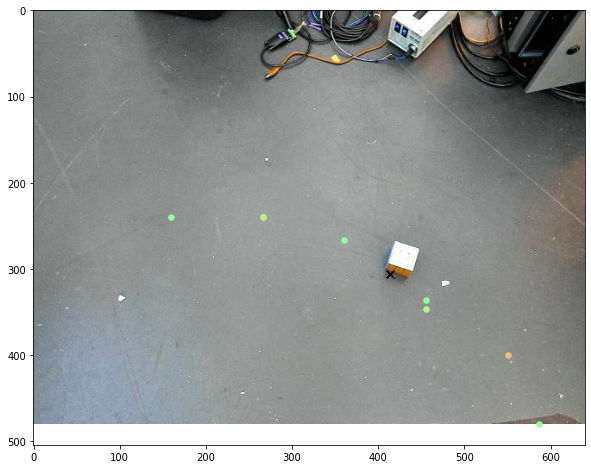

In [35]:
plotTreeOnImage(tree, img)
plt.show()

In [37]:
pxLoc = assemblePxTree(tree)
pick_vec = geometry_pb2.Vec2(x=pxLoc[0], y=pxLoc[1])

grasp = manipulation_api_pb2.PickObjectInImage(
    pixel_xy=pick_vec, transforms_snapshot_for_camera=image_response.shot.transforms_snapshot,
    frame_name_image_sensor=image_response.shot.frame_name_image_sensor,
    camera_model=image_response.source.pinhole)

grasp_request = manipulation_api_pb2.ManipulationApiRequest(pick_object_in_image=grasp)

In [38]:
makeGrasp(grasp_request, graph_nav_client)

Current state:  MANIP_STATE_ATTEMPTING_RAYCASTING
Current state:  MANIP_STATE_WALKING_TO_OBJECT
Current state:  MANIP_STATE_SEARCHING_FOR_GRASP
Current state:  MANIP_STATE_SEARCHING_FOR_GRASP
Current state:  MANIP_STATE_SEARCHING_FOR_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current stat

In [39]:
cmd = RobotCommandBuilder.arm_stow_command()
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)
bdcrc.block_until_arm_arrives(command_client, cmd_id, timeout_sec = time.time() + 3.0)

bdcrc.blocking_sit(command_client, timeout_sec = timeoutSec)

In [40]:
cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)

In [174]:
frameTreeSnapshot = robot.get_frame_tree_snapshot()
cmd = RobotCommandBuilder.synchro_trajectory_command_in_body_frame(-0.3, 0, 0, frame_tree_snapshot = frameTreeSnapshot)
cmd_id = cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
bdcrc.block_for_trajectory_cmd(command_client, cmd_id)



True

In [60]:
#waypointDict = graphInit(graph_nav_client, upload_filepath)
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[10], timeoutSec)
waitUntilFinishedNav(nav_to_cmd_id)

In [61]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[9], timeoutSec)
waitUntilFinishedNav(nav_to_cmd_id)
frameTreeSnapshot = robot.get_frame_tree_snapshot()
cmd = RobotCommandBuilder.synchro_trajectory_command_in_body_frame(0, 0, np.pi/2, frame_tree_snapshot = frameTreeSnapshot)
cmd_id = cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
bdcrc.block_for_trajectory_cmd(command_client, cmd_id)

True

In [37]:
frameTreeSnapshot = robot.get_frame_tree_snapshot()
cmd = RobotCommandBuilder.synchro_trajectory_command_in_body_frame(0, 0, np.pi/3, frame_tree_snapshot = frameTreeSnapshot)
cmd_id = cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)
bdcrc.block_for_trajectory_cmd(command_client, cmd_id)

True

In [121]:
res = checkForCubeAndGrasp(det, graph_nav_client)

Gripper opening
looking down
RUBIK'S CUBE FOUND and localized
Current state:  MANIP_STATE_SEARCHING_FOR_GRASP
Current state:  MANIP_STATE_SEARCHING_FOR_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Current state:  MANIP_STATE_MOVING_TO_GRASP
Curren

In [183]:
cmd = RobotCommandBuilder.arm_stow_command()
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)
bdcrc.block_until_arm_arrives(command_client, cmd_id, timeout_sec = time.time() + 3.0)

bdcrc.blocking_sit(command_client, timeout_sec = timeoutSec)

cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)

In [297]:
cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(1.0)
cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+timeoutSec)

In [309]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[10], timeoutSec)

RobotNotLocalizedToRouteError: bosdyn.api.graph_nav.NavigateToResponse (RobotNotLocalizedToRouteError): The current localization doesn't refer to any waypoint in the route (possibly uninitialized localization).

In [240]:
nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[9], timeoutSec)
waitUntilFinishedNav(nav_to_cmd_id)



True

In [249]:
# image_query = makeGLAPICall(det, graph_nav_client)

# grasp_request = None
# if image_query.result.label == 'PASS':
#     grasp_request = localizeObject()
#     print("RUBIK'S CUBE FOUND and localized")
# else:
#     print("NO RUBIK'S CUBE FOUND, continuing walk")
#     cmd = RobotCommandBuilder.claw_gripper_open_fraction_command(0.0)
    
    
# if grasp_request is not None:
#     makeGrasp(grasp_request)
#     print("GRASP MADE")
    
    
# cmd = RobotCommandBuilder.arm_stow_command()
# cmd_id = command_client.robot_command(cmd, end_time_secs = time.time()+5)

# waypointDict = graphInit(graph_nav_client, upload_filepath)
# nav_to_cmd_id = graph_nav_client.navigate_to(waypointDict[10], timeoutSec)

Arm Ready
Gripper opening
looking down
NO RUBIK'S CUBE FOUND, continuing walk


AttributeError: type object 'RobotCommandBuilder' has no attribute 'gripper_close_command'